# BROWN SPOT DISEASE DETECTION

Import all the Dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML


Set all the Constants

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=100

Import data into tensorflow dataset objec

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "brownspot-dataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1433 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['healthy_padddy', 'mild_brown_spot', 'servere_brown_spot']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 2 2 1 2 2 0 0 1 0 0 1 2 0 2 0 2 2 2 2 2 1 2 0 2 0 2 0 1 2 1 1]


Visualize some of the images from our dataset

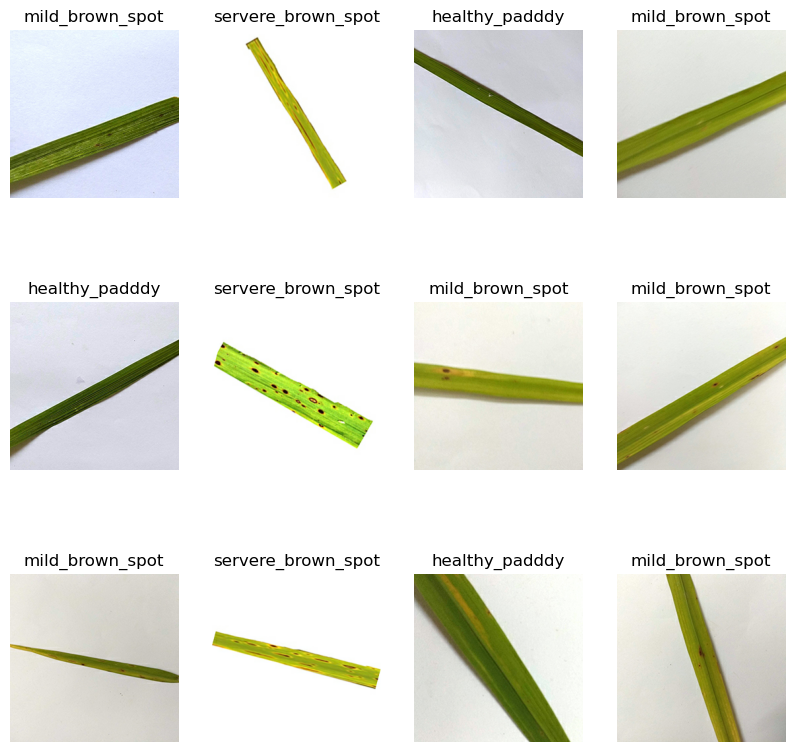

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

Function to Split Dataset

In [7]:
len(dataset)

45

In [8]:
train_size = 0.8
len(dataset)*train_size

36.0

In [9]:
train_ds = dataset.take(54)
len(train_ds)

45

In [10]:
test_ds = dataset.skip(54)
len(test_ds)

0

In [11]:
val_size=0.1
len(dataset)*val_size

4.5

In [12]:
val_ds = test_ds.take(6)
len(val_ds)


0

In [13]:
test_ds = test_ds.skip(6)
len(test_ds)

0

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

36

In [17]:
len(val_ds)

4

In [18]:
len(test_ds)

5

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Building the Model

In [20]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

Data Augmentation

In [21]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

Applying Data Augmentation to Train Dataset

In [22]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Model Architecture

In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

Compiling the Model

We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=100,
)

Epoch 1/100
36/36 [==============================] - 79s 2s/step - loss: 1.0177 - accuracy: 0.4341 - val_loss: 0.8666 - val_accuracy: 0.5469
Epoch 2/100
36/36 [==============================] - 72s 2s/step - loss: 0.7061 - accuracy: 0.6934 - val_loss: 0.5851 - val_accuracy: 0.6953
Epoch 3/100
36/36 [==============================] - 68s 2s/step - loss: 0.5474 - accuracy: 0.7633 - val_loss: 0.5018 - val_accuracy: 0.7578
Epoch 4/100
36/36 [==============================] - 48s 1s/step - loss: 0.5136 - accuracy: 0.7624 - val_loss: 0.4626 - val_accuracy: 0.7500
Epoch 5/100
36/36 [==============================] - 39s 1s/step - loss: 0.4512 - accuracy: 0.8044 - val_loss: 0.4707 - val_accuracy: 0.7812
Epoch 6/100
36/36 [==============================] - 72s 2s/step - loss: 0.4658 - accuracy: 0.8026 - val_loss: 0.3956 - val_accuracy: 0.8281
Epoch 7/100
36/36 [==============================] - 69s 2s/step - loss: 0.4254 - accuracy: 0.8157 - val_loss: 0.3460 - val_accuracy: 0.8281
Epoch 8/100
3

Epoch 59/100
36/36 [==============================] - 37s 1s/step - loss: 0.1343 - accuracy: 0.9467 - val_loss: 0.1825 - val_accuracy: 0.9453
Epoch 60/100
36/36 [==============================] - 37s 1s/step - loss: 0.0931 - accuracy: 0.9659 - val_loss: 0.1891 - val_accuracy: 0.9297
Epoch 61/100
36/36 [==============================] - 37s 1s/step - loss: 0.1000 - accuracy: 0.9581 - val_loss: 0.2246 - val_accuracy: 0.9531
Epoch 62/100
36/36 [==============================] - 37s 1s/step - loss: 0.0877 - accuracy: 0.9616 - val_loss: 0.1822 - val_accuracy: 0.9453
Epoch 63/100
36/36 [==============================] - 37s 1s/step - loss: 0.0897 - accuracy: 0.9677 - val_loss: 0.2002 - val_accuracy: 0.9609
Epoch 64/100
36/36 [==============================] - 37s 1s/step - loss: 0.1183 - accuracy: 0.9563 - val_loss: 0.1671 - val_accuracy: 0.9531
Epoch 65/100
36/36 [==============================] - 37s 1s/step - loss: 0.0842 - accuracy: 0.9712 - val_loss: 0.2001 - val_accuracy: 0.9531
Epoch 

In [27]:
scores = model.evaluate(test_ds)

5/5 [==============================] - 2s 258ms/step - loss: 0.0220 - accuracy: 1.0000


In [28]:
scores

[0.021985094994306564, 1.0]

Plotting the Accuracy and Loss Curves

In [29]:
history

In [30]:
history.params

{'verbose': 1, 'epochs': 100, 'steps': 36}

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch

In [32]:
type(history.history['loss'])

list

In [33]:
len(history.history['loss'])

100

In [34]:
history.history['loss'][:10] # show loss for first 10 epochs

[1.017675518989563,
 0.7061190009117126,
 0.5473961234092712,
 0.5135979652404785,
 0.4511796534061432,
 0.4658207893371582,
 0.4253551661968231,
 0.3750828504562378,
 0.4131760001182556,
 0.36574840545654297]

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

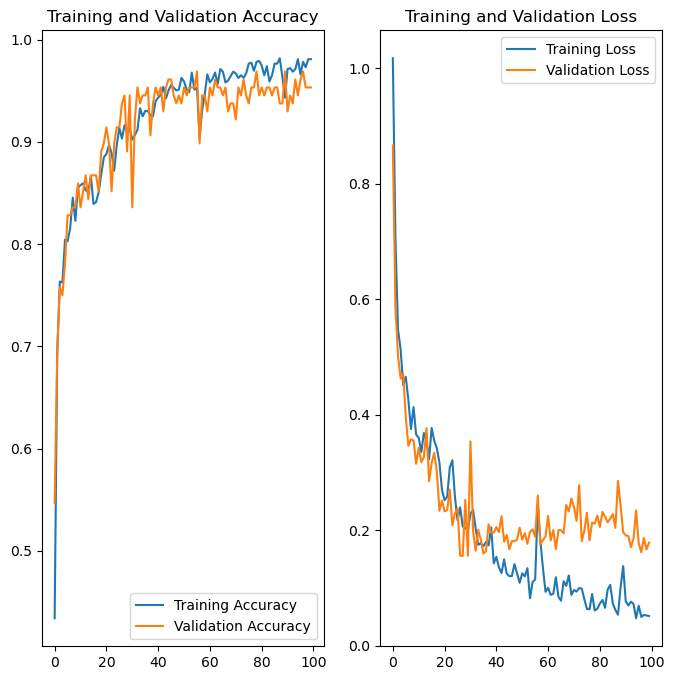

In [36]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Run prediction on a sample image

first image to predict
actual label: mild_brown_spot
predicted label: mild_brown_spot


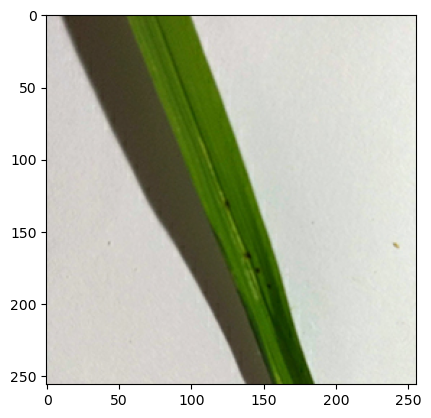

In [37]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

Write a function for inference

In [38]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

Now run inference on few sample images

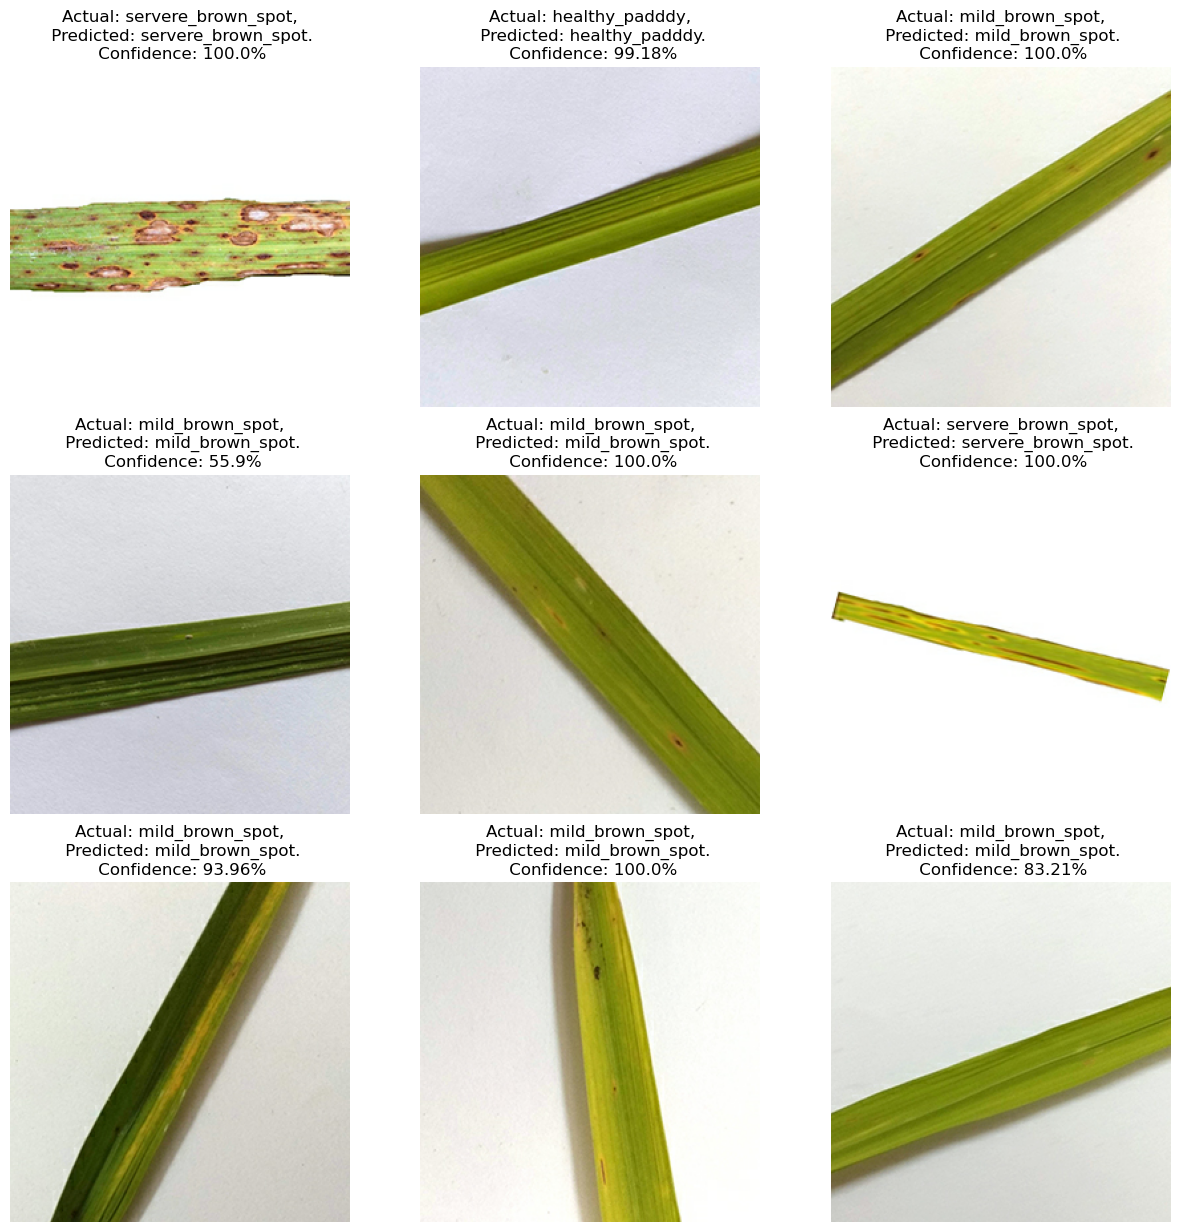

In [39]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

Saving the Model

In [40]:
##import os
##model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
#model.save(f"../models/{model_version}")

In [41]:
##model.save("../brownspot.h5")

In [42]:
from sklearn.metrics import confusion_matrix

# Evaluate the model on test set and print scores
scores = model.evaluate(test_ds)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# Predict classes for test set
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true classes for test set
y_true = []
for images, labels in test_ds:
    y_true.extend(labels.numpy())

# Get confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
print('Confusion matrix:')
print(cm)


5/5 [==============================] - 1s 251ms/step - loss: 0.0220 - accuracy: 1.0000
Test loss: 0.021985094994306564
Test accuracy: 1.0
Confusion matrix:
[[37  8 15]
 [10 32  7]
 [13  9 29]]


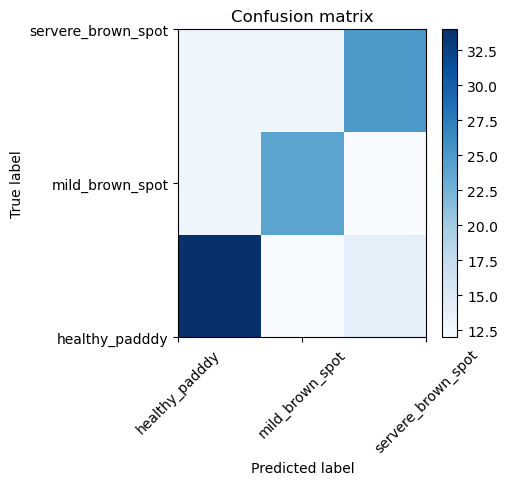

In [43]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Make predictions on the test dataset
y_pred = np.argmax(model.predict(test_ds), axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix as a histogram
plt.figure(figsize=(4, 4))
plt.hist2d(y_true, y_pred, bins=(len(class_names), len(class_names)), cmap=plt.cm.Blues)
plt.colorbar()
plt.xlabel('Predicted label')
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.ylabel('True label')
plt.yticks(range(len(class_names)), class_names)
plt.title('Confusion matrix')
plt.show()


In [44]:
from sklearn.metrics import classification_report

# predict class probabilities for test set
y_pred_proba = model.predict(test_ds)

# get class predictions from probabilities
y_pred = tf.argmax(y_pred_proba, axis=1)

# get true labels for test set
y_true = []
for x, y in test_ds:
    y_true.extend(y.numpy())

# generate classification report
target_names = ['Healthy', 'Mild', 'Severe']
print(classification_report(y_true, y_pred, target_names=target_names))


              precision    recall  f1-score   support

     Healthy       0.45      0.45      0.45        60
        Mild       0.51      0.51      0.51        49
      Severe       0.39      0.39      0.39        51

    accuracy                           0.45       160
   macro avg       0.45      0.45      0.45       160
weighted avg       0.45      0.45      0.45       160

